In [1]:
%reset -f

/tmp/ipykernel_14597/42032200.py:31: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  weather_df = pd.read_csv(


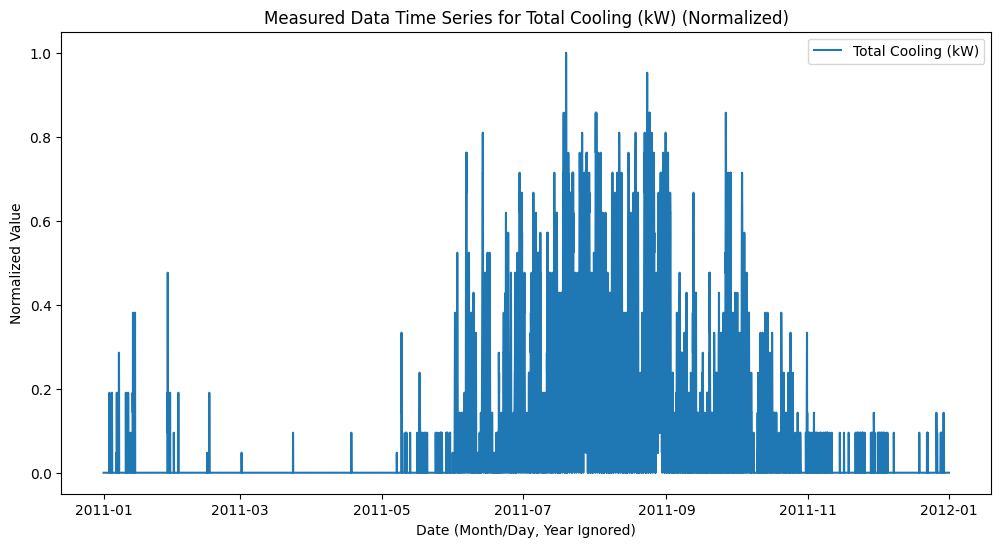

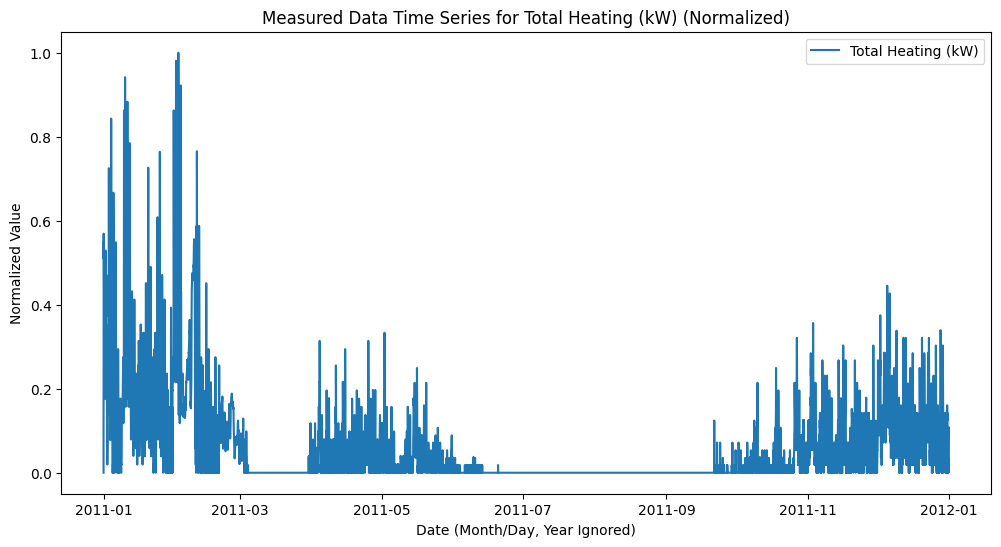

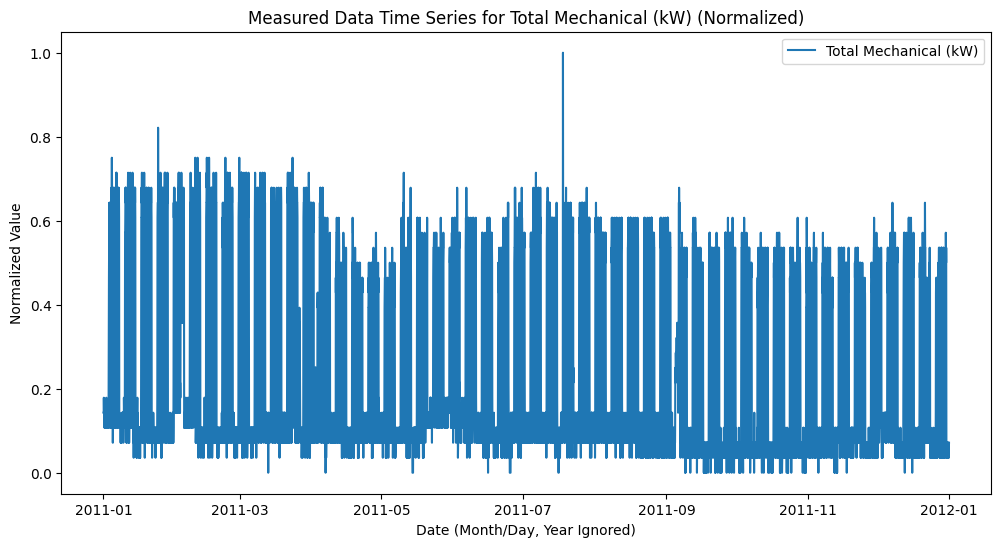

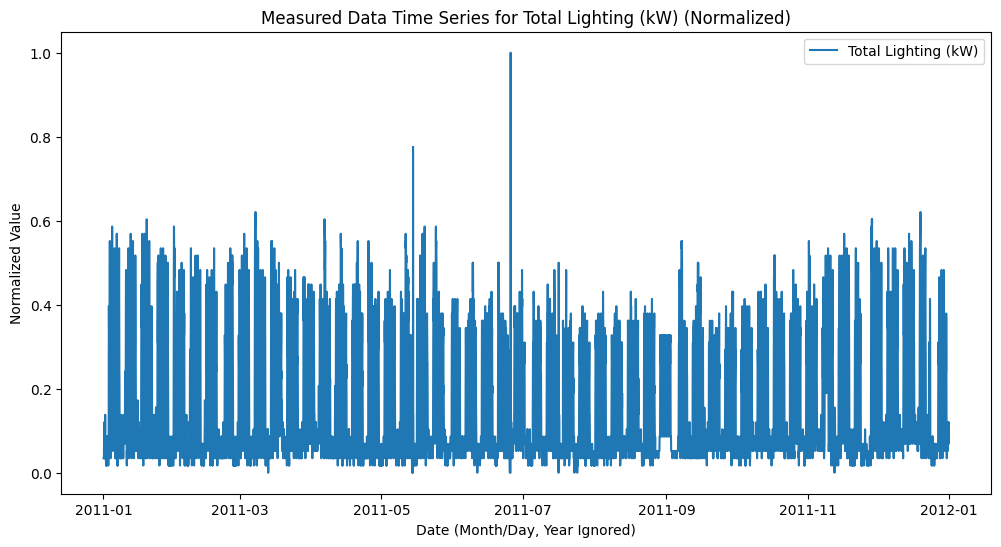

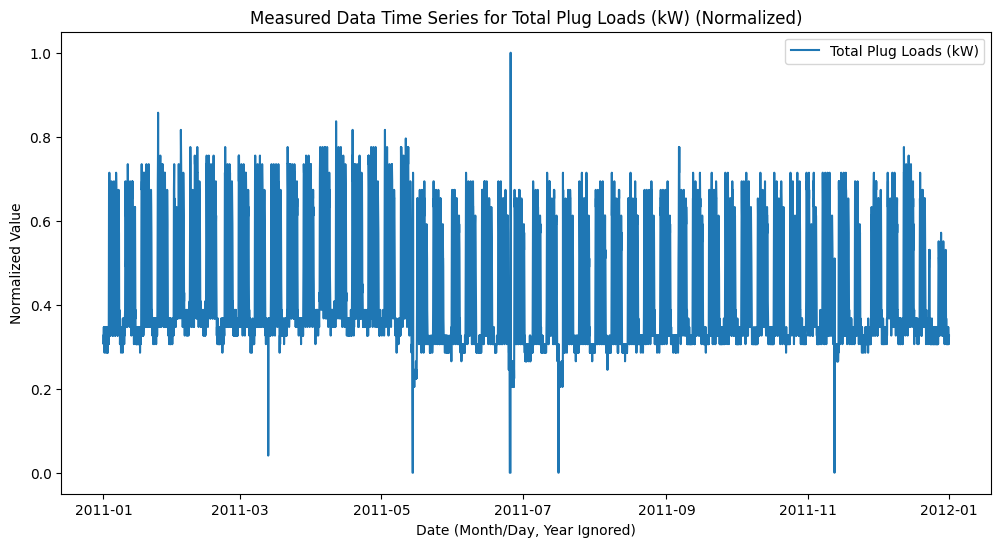

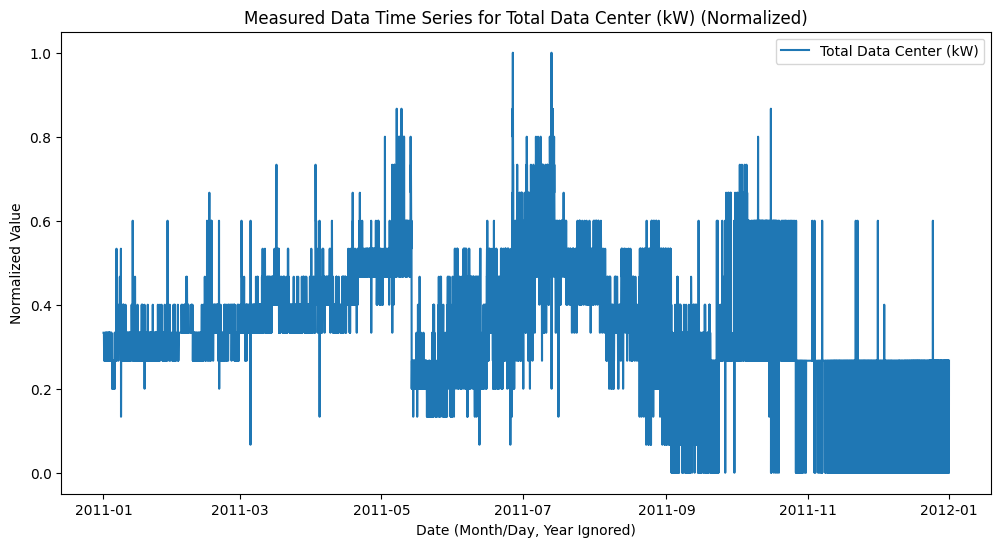

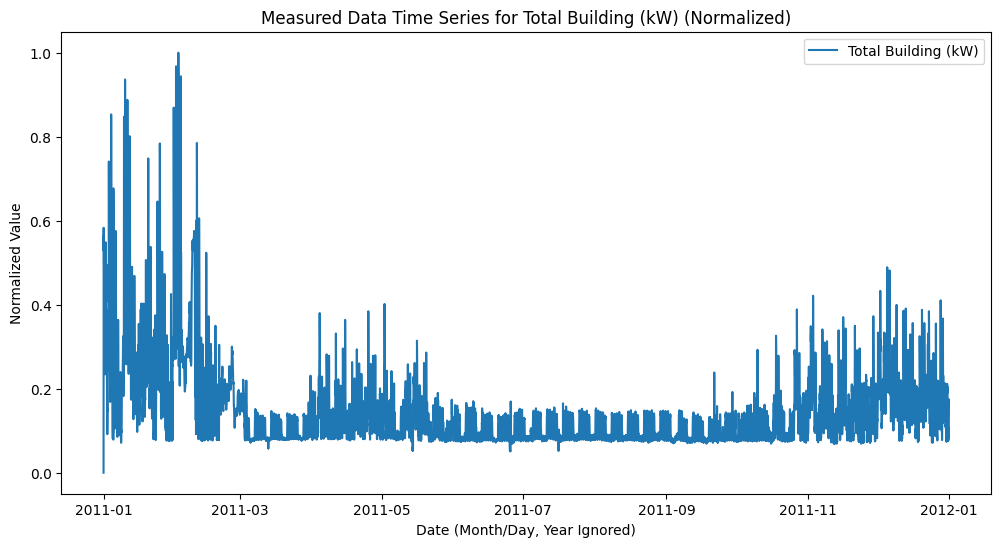

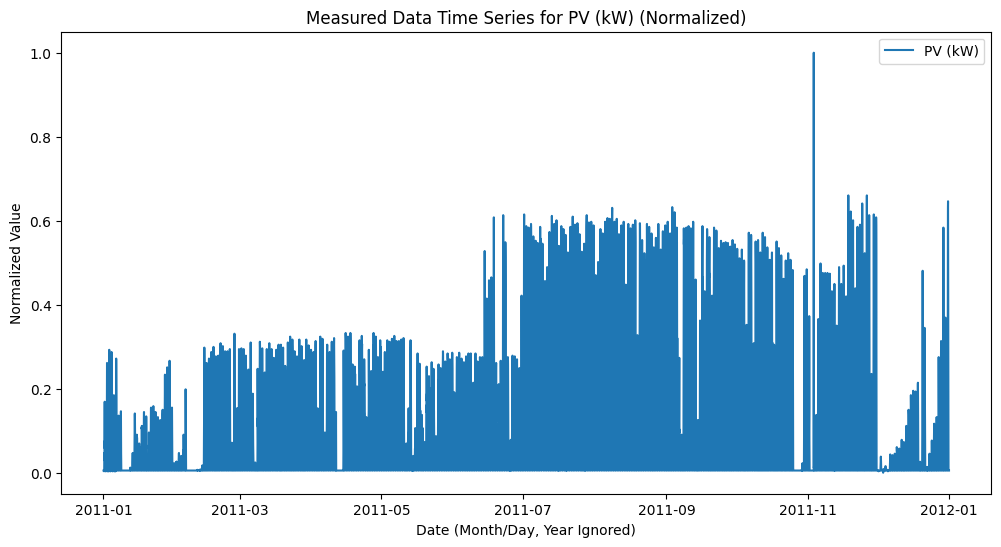

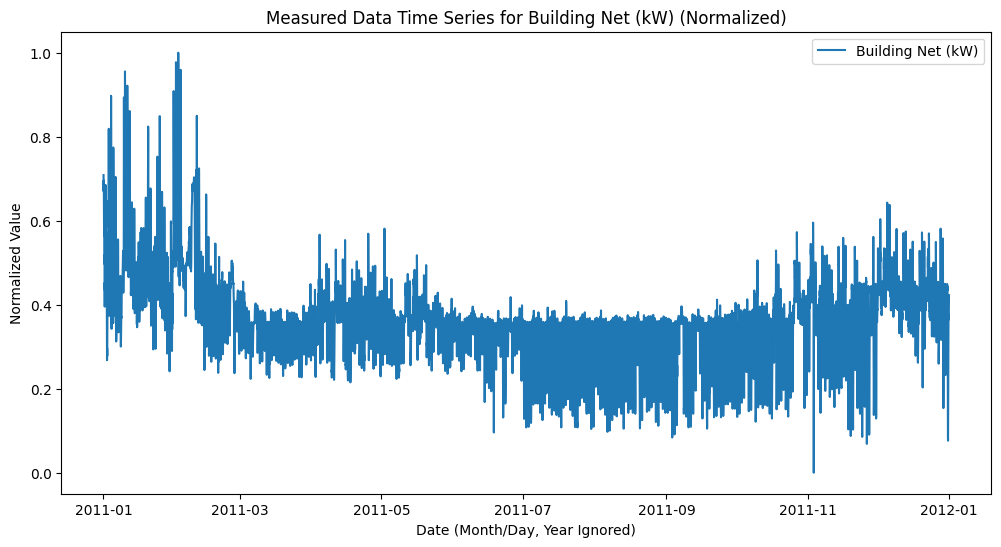

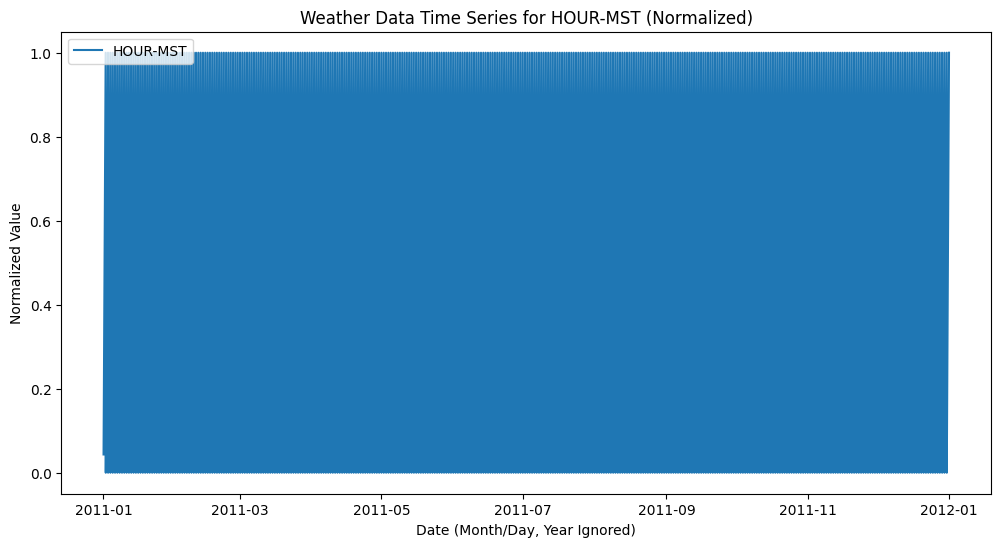

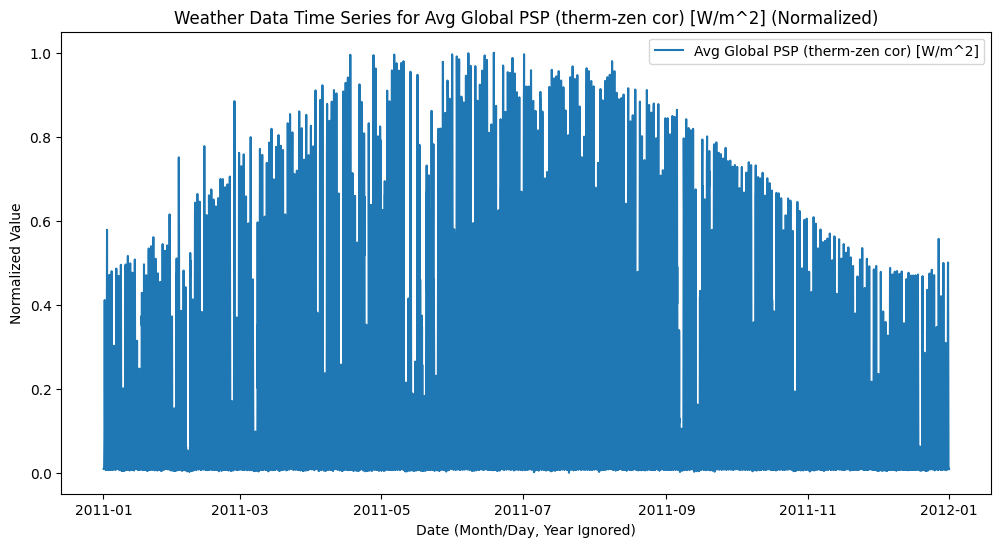

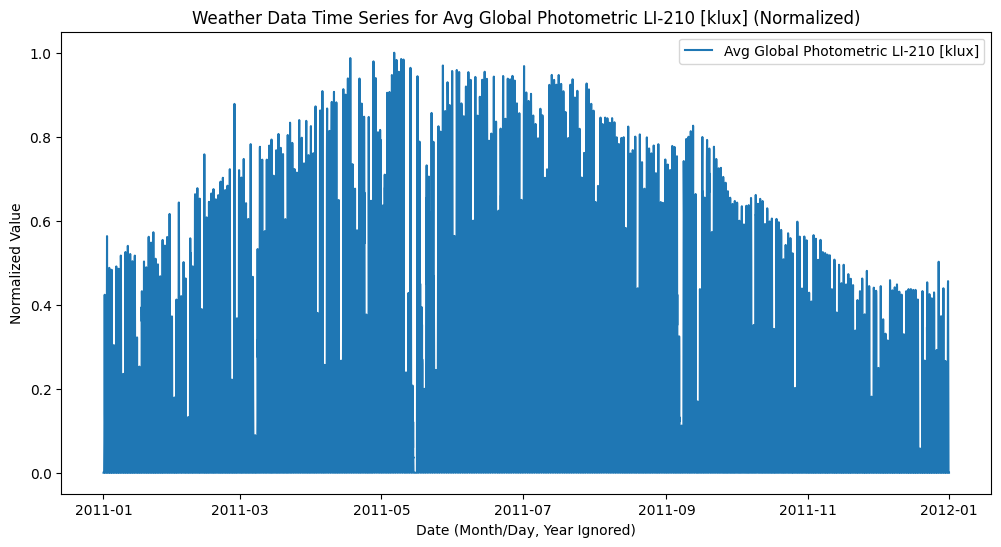

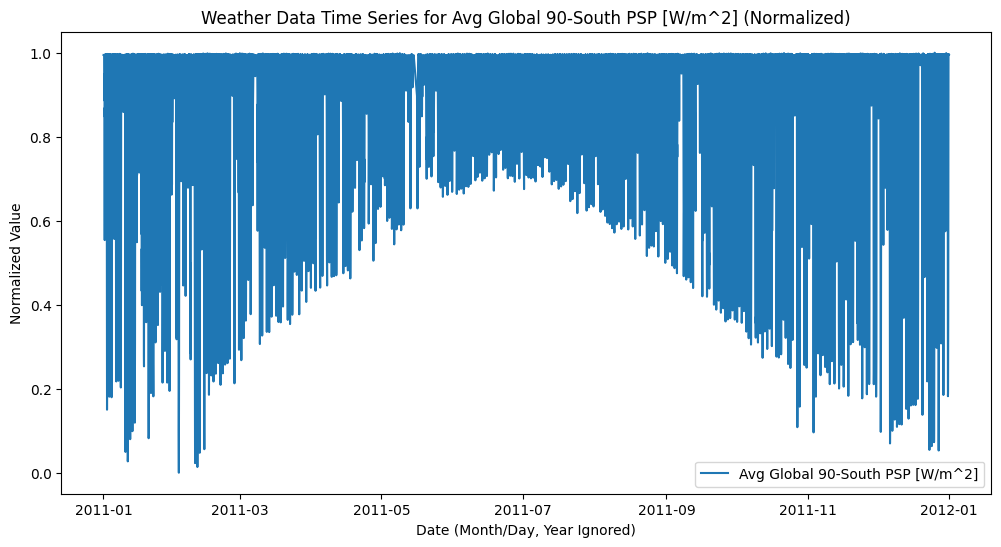

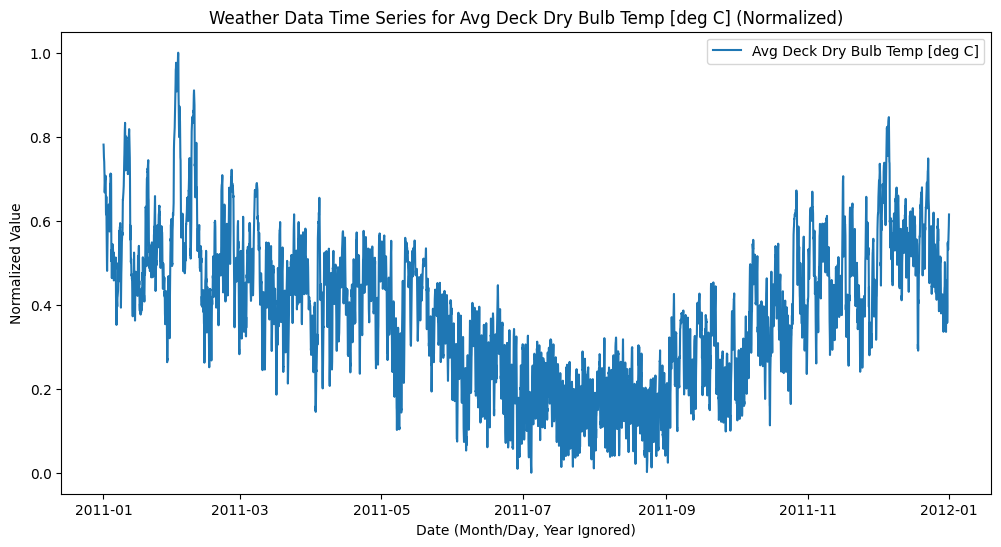

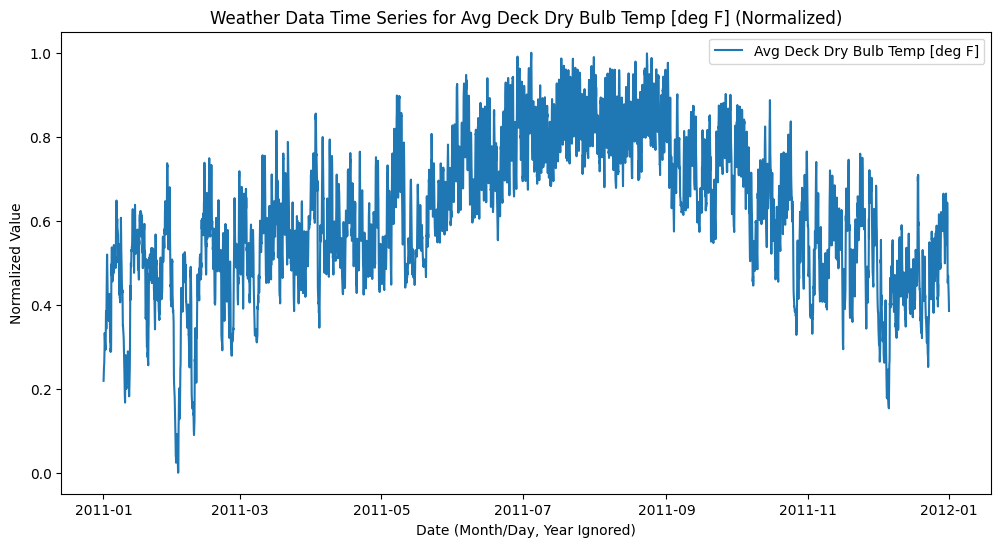

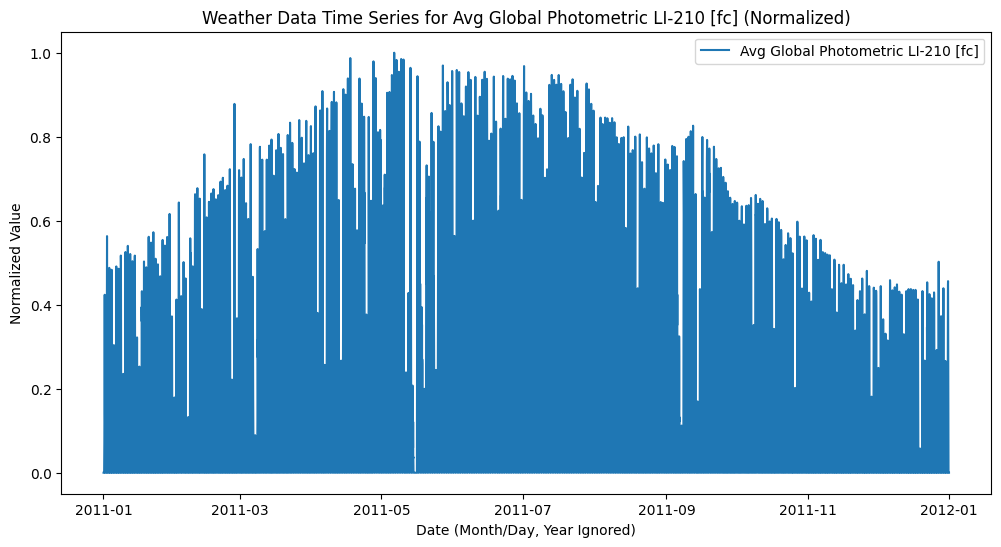

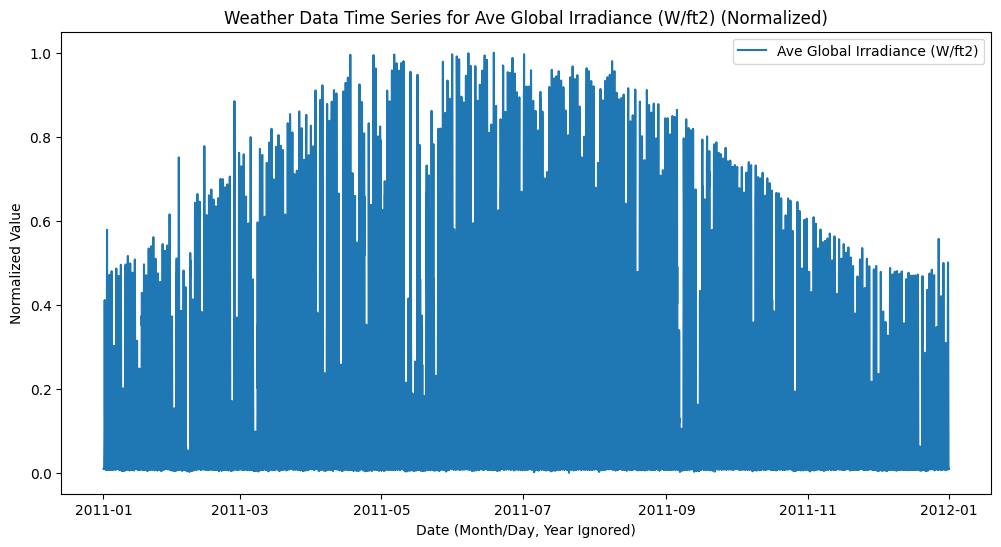

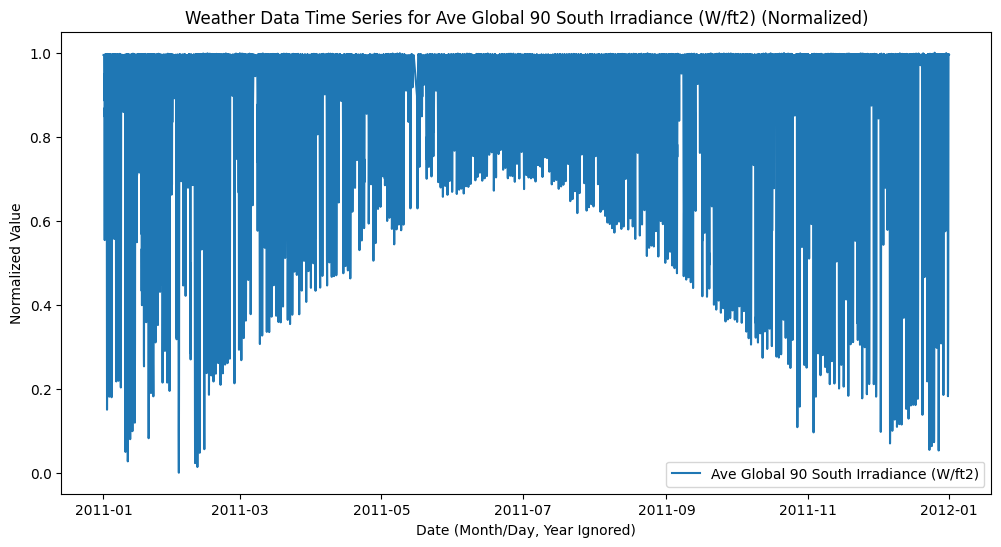

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_measured_date(date_str):
    """
    Try to parse a date string using two possible formats.
    Returns NaT if neither format works.
    """
    for fmt in ("%m/%d/%Y %H:%M", "%m/%d/%y %H:%M"):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except Exception:
            continue
    return pd.NaT

# ------------------------------
# Process Measured Data
# ------------------------------
measured_df = pd.read_csv("rsfmeasureddata2011.csv")
# Parse dates
measured_df["Date and Time"] = measured_df["Date and Time"].apply(parse_measured_date)
measured_df = measured_df.dropna(subset=["Date and Time"])
# Replace year with 2011 (to ignore year differences)
measured_df["Date and Time"] = measured_df["Date and Time"].apply(lambda dt: dt.replace(year=2011))
measured_df.set_index("Date and Time", inplace=True)

# ------------------------------
# Process Weather Data
# ------------------------------
weather_df = pd.read_csv(
    "rsfweatherdata2011.csv",
    parse_dates=["DATE AND TIME"],
    date_parser=lambda x: pd.to_datetime(x, format="%m/%d/%y %H:%M", errors='coerce')
)
weather_df = weather_df.dropna(subset=["DATE AND TIME"])
weather_df["DATE AND TIME"] = weather_df["DATE AND TIME"].apply(lambda dt: dt.replace(year=2011))
weather_df.set_index("DATE AND TIME", inplace=True)

# ------------------------------
# Normalization and Sensor Error Correction for Measured Data
# ------------------------------
# Work on a copy for measured data normalization.
measured_df_norm = measured_df.copy()

# Flip sign for "PV (kW)" because values are negative.
if "PV (kW)" in measured_df_norm.columns:
    measured_df_norm["PV (kW)"] = -measured_df_norm["PV (kW)"]

# Select columns to normalize
measured_cols  = ["Total Cooling (kW)", "Total Heating (kW)", "Total Mechanical (kW)", "Total Lighting (kW)","Total Plug Loads (kW)", "Total Data Center (kW)", "Total Building (kW)", "PV (kW)","Building Net (kW)"]

#measured_cols = ["Total Building (kW)", "PV (kW)"]
measured_df_norm[measured_cols] = (measured_df_norm[measured_cols] - measured_df_norm[measured_cols].min()) / \
                                  (measured_df_norm[measured_cols].max() - measured_df_norm[measured_cols].min())

# ------------------------------
# Normalization and Sensor Error Correction for Weather Data
# ------------------------------
# Convert weather data columns to numeric and drop entirely non-numeric ones.
numeric_weather_df = weather_df.apply(pd.to_numeric, errors='coerce')
numeric_weather_df = numeric_weather_df.dropna(axis=1, how='all')

# Flip sign for selected weather columns.
# Here we flip three columns as per previous instruction.
cols_to_flip = [
    "Avg Global 90-South PSP [W/m^2]",
    "Avg Deck Dry Bulb Temp [deg C]",
    "Ave Global 90 South Irradiance (W/ft2)"
]
for col in cols_to_flip:
    if col in numeric_weather_df.columns:
        numeric_weather_df[col] = -numeric_weather_df[col]

# --- Sensor Error Correction (Option 1: Time-based interpolation) ---
# Define the error period.
error_start = pd.to_datetime("2011-05-14 23:00")
error_end = pd.to_datetime("2011-05-16 07:00")
error_mask = (numeric_weather_df.index >= error_start) & (numeric_weather_df.index <= error_end)

# Specify the columns with sensor errors (only for the two irradiance/PSP columns).
cols_error = ["Avg Global 90-South PSP [W/m^2]", "Ave Global 90 South Irradiance (W/ft2)"]
# Set the error period values to NaN.
numeric_weather_df.loc[error_mask, cols_error] = np.nan

# Apply time-based interpolation (based on the datetime index) to these columns.
numeric_weather_df[cols_error] = numeric_weather_df[cols_error].interpolate(method='time')

# Now normalize all numeric weather columns.
numeric_weather_df_norm = (numeric_weather_df - numeric_weather_df.min()) / (numeric_weather_df.max() - numeric_weather_df.min())

# ------------------------------
# Plotting the Full Measured Data
# ------------------------------
for col in measured_cols:
    plt.figure(figsize=(12, 6))
    plt.plot(measured_df_norm.index, measured_df_norm[col], label=col)
    plt.xlabel("Date (Month/Day, Year Ignored)")
    plt.ylabel("Normalized Value")
    plt.title(f"Measured Data Time Series for {col} (Normalized)")
    plt.legend()
    plt.show()

# ------------------------------
# Plotting the Full Weather Data
# ------------------------------
for col in numeric_weather_df_norm.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(numeric_weather_df_norm.index, numeric_weather_df_norm[col], label=col)
    plt.xlabel("Date (Month/Day, Year Ignored)")
    plt.ylabel("Normalized Value")
    plt.title(f"Weather Data Time Series for {col} (Normalized)")
    plt.legend()
    plt.show()

               Measured                                 Weather  Euclidean  \
0   Total Building (kW)                                HOUR-MST  44.904457   
1   Total Building (kW)  Avg Global PSP (therm-zen cor) [W/m^2]  27.003493   
2   Total Building (kW)    Avg Global Photometric LI-210 [klux]  26.155476   
3   Total Building (kW)         Avg Global 90-South PSP [W/m^2]  70.876145   
4   Total Building (kW)          Avg Deck Dry Bulb Temp [deg C]  25.932299   
5   Total Building (kW)          Avg Deck Dry Bulb Temp [deg F]  49.597276   
6   Total Building (kW)      Avg Global Photometric LI-210 [fc]  26.155476   
7   Total Building (kW)           Ave Global Irradiance (W/ft2)  27.003493   
8   Total Building (kW)  Ave Global 90 South Irradiance (W/ft2)  70.876145   
9               PV (kW)                                HOUR-MST  48.193771   
10              PV (kW)  Avg Global PSP (therm-zen cor) [W/m^2]  17.683361   
11              PV (kW)    Avg Global Photometric LI-210 [klux] 

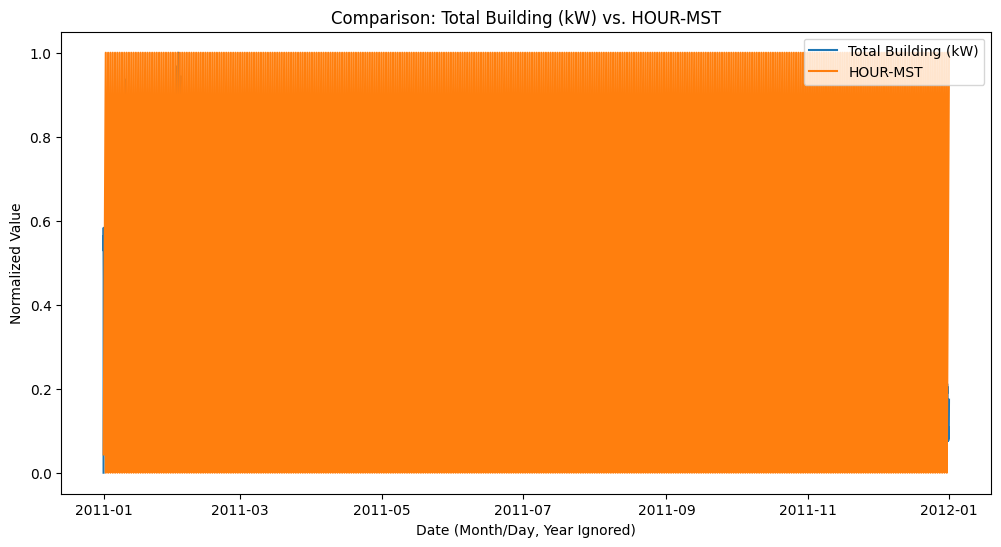

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.fft import fft

# ------------------------------
# Define Helper Functions for Metrics
# ------------------------------

def align_series(ts1, ts2):
    """Align two pandas Series on their common datetime index."""
    common_index = ts1.index.intersection(ts2.index)
    return ts1.loc[common_index], ts2.loc[common_index]

def euclidean_distance(ts1, ts2):
    """Compute direct Euclidean distance between two time series."""
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    return np.linalg.norm(s1.values - s2.values)

def fft_euclidean_distance(ts1, ts2):
    """Compute Euclidean distance between FFT magnitudes of two time series."""
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Compute FFT for each series
    fft1 = fft(s1.values)
    fft2 = fft(s2.values)
    # Compare the magnitudes (absolute values)
    return np.linalg.norm(np.abs(fft1) - np.abs(fft2))

def kl_divergence(p, q, eps=1e-10):
    """
    Compute the KL divergence from p to q.
    p and q should be numpy arrays that sum to 1.
    """
    p = p + eps
    q = q + eps
    return np.sum(p * np.log(p / q))

def symmetric_kl(ts1, ts2, eps=1e-10):
    """
    Compute a symmetric KL divergence between two time series.
    The series are converted to probability distributions by subtracting the minimum
    (to ensure non-negativity) and normalizing so the sum is 1.
    """
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Shift series so that the minimum is zero (if needed)
    arr1 = s1.values - s1.values.min()
    arr2 = s2.values - s2.values.min()
    # Normalize to form probability distributions.
    p = arr1 / (arr1.sum() + eps)
    q = arr2 / (arr2.sum() + eps)
    return 0.5 * (kl_divergence(p, q, eps) + kl_divergence(q, p, eps))

def wavelet_energy_distance(ts1, ts2, wavelet='db1', level=None):
    """
    Compute the Euclidean distance between the normalized wavelet energy distributions
    of two time series.
    The energy at each level is computed as the sum of squares of the coefficients.
    """
    s1, s2 = align_series(ts1, ts2)
    if len(s1) == 0:
        return np.nan
    # Compute the discrete wavelet transform decomposition.
    coeffs1 = pywt.wavedec(s1.values, wavelet, level=level)
    coeffs2 = pywt.wavedec(s2.values, wavelet, level=level)
    # Compute energy for each set of coefficients.
    energy1 = np.array([np.sum(c**2) for c in coeffs1])
    energy2 = np.array([np.sum(c**2) for c in coeffs2])
    # Normalize energy vectors so they sum to 1.
    energy1 = energy1 / energy1.sum()
    energy2 = energy2 / energy2.sum()
    return np.linalg.norm(energy1 - energy2)

# ------------------------------
# Assume Measured and Weather Data are Already Normalized
# ------------------------------
# measured_df_norm: DataFrame containing measured data with columns "Total Building (kW)" and "PV (kW)"
# numeric_weather_df_norm: DataFrame containing normalized weather data.
#
# For this example, we assume that measured_df_norm and numeric_weather_df_norm have been computed
# from your previous processing steps.

# (For demonstration, here we simulate small sample series with matching datetime indexes.)
# Uncomment and remove the following sample simulation if you already have your processed DataFrames.
#"""
#rng = pd.date_range('2011-01-01', periods=1000, freq='H')
#measured_df_norm = pd.DataFrame({
#    "Total Building (kW)": np.random.rand(1000),
#    "PV (kW)": np.random.rand(1000)
#}, index=rng)
#weather_cols = ["Avg Global PSP (therm-zen cor) [W/m^2]", "Avg Global Photometric LI-210 [klux]"]
#numeric_weather_df_norm = pd.DataFrame({
#    weather_cols[0]: np.random.rand(1000),
#    weather_cols[1]: np.random.rand(1000)
#}, index=rng)
#"""

# Specify the measured columns and weather columns you want to compare.
measured_cols = ["Total Building (kW)", "PV (kW)"]
# For weather, you can compare all columns or a subset. Here we use all numeric columns.
weather_cols = numeric_weather_df_norm.columns

# ------------------------------
# Compute the Metrics for Each Pair
# ------------------------------
results = []
for mcol in measured_cols:
    for wcol in weather_cols:
        ts_measured = measured_df_norm[mcol]
        ts_weather = numeric_weather_df_norm[wcol]
        
        ed = euclidean_distance(ts_measured, ts_weather)
        fft_ed = fft_euclidean_distance(ts_measured, ts_weather)
        kl_div = symmetric_kl(ts_measured, ts_weather)
        wavelet_ed = wavelet_energy_distance(ts_measured, ts_weather, wavelet='db1')  # using default wavelet
        
        results.append({
            "Measured": mcol,
            "Weather": wcol,
            "Euclidean": ed,
            "FFT Euclidean": fft_ed,
            "KL Divergence": kl_div,
            "Wavelet Energy Distance": wavelet_ed
        })

# Convert results to a DataFrame for a nice display.
results_df = pd.DataFrame(results)
print(results_df)

# ------------------------------
# Optionally: Plot the two series for visual inspection.
# For example, plot "Total Building (kW)" vs. a selected weather variable.
# ------------------------------
example_measured = measured_cols[0]  # "Total Building (kW)"
example_weather = weather_cols[0]      # first weather column

plt.figure(figsize=(12,6))
plt.plot(measured_df_norm.index, measured_df_norm[example_measured], label=example_measured)
plt.plot(numeric_weather_df_norm.index, numeric_weather_df_norm[example_weather], label=example_weather)
plt.xlabel("Date (Month/Day, Year Ignored)")
plt.ylabel("Normalized Value")
plt.title(f"Comparison: {example_measured} vs. {example_weather}")
plt.legend()
plt.show()

In [4]:
measured_df_norm_fordata = measured_df_norm.iloc[:,1:10]
df_en = measured_df_norm_fordata
df_en.fillna(method='bfill', inplace=True)
energy_data = df_en
energy_data.shape

/tmp/ipykernel_14597/886121869.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_en.fillna(method='bfill', inplace=True)


(8760, 9)

In [5]:
energy_data.head()

,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW)
Date and Time,,,,,,,,,
2011-01-01 00:00:00,0.0,0.000000,0.142857,0.034483,0.326531,0.333333,0.000000,0.005226,0.708679
2011-01-01 01:00:00,0.0,0.569343,0.142857,0.034483,0.326531,0.333333,0.583153,0.005226,0.708679
2011-01-01 02:00:00,0.0,0.509732,0.142857,0.034483,0.306122,0.333333,0.528078,0.005226,0.670189
2011-01-01 03:00:00,0.0,0.549878,0.142857,0.034483,0.326531,0.333333,0.564795,0.005226,0.695849
2011-01-01 04:00:00,0.0,0.509732,0.178571,0.034483,0.346939,0.333333,0.531317,0.005226,0.672453


In [6]:
weather_data = numeric_weather_df_norm.iloc[:,1:]
df_we = weather_data
df_we.fillna(method='bfill', inplace=True)

weather_data = df_we
weather_data.head()

/tmp/ipykernel_14597/2692697010.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_we.fillna(method='bfill', inplace=True)


,Avg Global PSP (therm-zen cor) [W/m^2],Avg Global Photometric LI-210 [klux],Avg Global 90-South PSP [W/m^2],Avg Deck Dry Bulb Temp [deg C],Avg Deck Dry Bulb Temp [deg F],Avg Global Photometric LI-210 [fc],Ave Global Irradiance (W/ft2),Ave Global 90 South Irradiance (W/ft2)
DATE AND TIME,,,,,,,,
2011-01-01 01:00:00,0.009392,0.0,0.994574,0.781230,0.218770,0.0,0.009392,0.994574
2011-01-01 02:00:00,0.009939,0.0,0.994440,0.776647,0.223353,0.0,0.009939,0.994440
2011-01-01 03:00:00,0.010029,0.0,0.994505,0.764742,0.235258,0.0,0.010029,0.994505
2011-01-01 04:00:00,0.009935,0.0,0.994603,0.758429,0.241571,0.0,0.009935,0.994603
2011-01-01 05:00:00,0.009740,0.0,0.994830,0.751300,0.248700,0.0,0.009740,0.994830


In [7]:
weather_data.columns

Index(['Avg Global PSP (therm-zen cor) [W/m^2]',
       'Avg Global Photometric LI-210 [klux]',
       'Avg Global 90-South PSP [W/m^2]', 'Avg Deck Dry Bulb Temp [deg C]',
       'Avg Deck Dry Bulb Temp [deg F]', 'Avg Global Photometric LI-210 [fc]',
       'Ave Global Irradiance (W/ft2)',
       'Ave Global 90 South Irradiance (W/ft2)'],
      dtype='object')

In [8]:
#the lengths do not match
hour_zero_row = weather_data.iloc[0].copy()
hour_zero_row.tolist()
new_row_df = pd.DataFrame([hour_zero_row], columns=weather_data.columns)
weather_data1 = pd.concat([new_row_df, weather_data], ignore_index=True)
weather_data1.shape

(8760, 8)

In [9]:
data_weather_Cshape = weather_data1

In [10]:
data_weather_Cshape.shape

(8760, 8)

In [12]:
data_weather_Cshape.head()

,Avg Global PSP (therm-zen cor) [W/m^2],Avg Global Photometric LI-210 [klux],Avg Global 90-South PSP [W/m^2],Avg Deck Dry Bulb Temp [deg C],Avg Deck Dry Bulb Temp [deg F],Avg Global Photometric LI-210 [fc],Ave Global Irradiance (W/ft2),Ave Global 90 South Irradiance (W/ft2)
0,0.009392,0.0,0.994574,0.781230,0.218770,0.0,0.009392,0.994574
1,0.009392,0.0,0.994574,0.781230,0.218770,0.0,0.009392,0.994574
2,0.009939,0.0,0.994440,0.776647,0.223353,0.0,0.009939,0.994440
3,0.010029,0.0,0.994505,0.764742,0.235258,0.0,0.010029,0.994505
4,0.009935,0.0,0.994603,0.758429,0.241571,0.0,0.009935,0.994603


In [13]:
col1 = data_weather_Cshape['Avg Global PSP (therm-zen cor) [W/m^2]'].tolist()
col2 = data_weather_Cshape['Avg Global Photometric LI-210 [klux]'].tolist()
col3 = data_weather_Cshape['Avg Global 90-South PSP [W/m^2]'].tolist()
col4 = data_weather_Cshape['Avg Deck Dry Bulb Temp [deg C]'].tolist()
col5 = data_weather_Cshape['Avg Deck Dry Bulb Temp [deg F]'].tolist()
col6 = data_weather_Cshape['Avg Global Photometric LI-210 [fc]'].tolist()
col7 = data_weather_Cshape['Ave Global Irradiance (W/ft2)'].tolist()
col8 = data_weather_Cshape['Ave Global 90 South Irradiance (W/ft2)'].tolist()

data_df = energy_data
data_df['Avg Global PSP (therm-zen cor) [W/m^2]'] = col1
data_df['Avg Global Photometric LI-210 [klux]'] = col2
data_df['Avg Global 90-South PSP [W/m^2]'] = col3
data_df['Avg Deck Dry Bulb Temp [deg C]'] = col4
data_df['Avg Deck Dry Bulb Temp [deg F]'] = col5
data_df['Avg Global Photometric LI-210 [fc]'] = col6
data_df['Ave Global Irradiance (W/ft2)'] = col7
data_df['Ave Global 90 South Irradiance (W/ft2)'] = col8
len(col3)

8760

In [14]:
data_df.to_csv('final_data.csv')

In [15]:
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

2025-04-08 04:09:17.291070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 04:09:17.291111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 04:09:17.292233: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 04:09:17.297903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 04:09:18.056724: W tensorflow/compiler/tf2

In [16]:
data_df.head()

,Total Cooling (kW),Total Heating (kW),Total Mechanical (kW),Total Lighting (kW),Total Plug Loads (kW),Total Data Center (kW),Total Building (kW),PV (kW),Building Net (kW),Avg Global PSP (therm-zen cor) [W/m^2],Avg Global Photometric LI-210 [klux],Avg Global 90-South PSP [W/m^2],Avg Deck Dry Bulb Temp [deg C],Avg Deck Dry Bulb Temp [deg F],Avg Global Photometric LI-210 [fc],Ave Global Irradiance (W/ft2),Ave Global 90 South Irradiance (W/ft2)
Date and Time,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.000000,0.142857,0.034483,0.326531,0.333333,0.000000,0.005226,0.708679,0.009392,0.0,0.994574,0.781230,0.218770,0.0,0.009392,0.994574
2011-01-01 01:00:00,0.0,0.569343,0.142857,0.034483,0.326531,0.333333,0.583153,0.005226,0.708679,0.009392,0.0,0.994574,0.781230,0.218770,0.0,0.009392,0.994574
2011-01-01 02:00:00,0.0,0.509732,0.142857,0.034483,0.306122,0.333333,0.528078,0.005226,0.670189,0.009939,0.0,0.994440,0.776647,0.223353,0.0,0.009939,0.994440
2011-01-01 03:00:00,0.0,0.549878,0.142857,0.034483,0.326531,0.333333,0.564795,0.005226,0.695849,0.010029,0.0,0.994505,0.764742,0.235258,0.0,0.010029,0.994505
2011-01-01 04:00:00,0.0,0.509732,0.178571,0.034483,0.346939,0.333333,0.531317,0.005226,0.672453,0.009935,0.0,0.994603,0.758429,0.241571,0.0,0.009935,0.994603


In [19]:
#variables for training
#lets pick variables with lowest wavelet energy distance and weather data columns

cols = list(data_df)[6:8]+list(data_df)[9:11]+list(data_df)[16:17]

print(cols)

['Total Building (kW)', 'PV (kW)', 'Avg Global PSP (therm-zen cor) [W/m^2]', 'Avg Global Photometric LI-210 [klux]', 'Ave Global 90 South Irradiance (W/ft2)']


In [20]:
df_for_training = data_df[cols].astype(float)
df_for_training.head()

,Total Building (kW),PV (kW),Avg Global PSP (therm-zen cor) [W/m^2],Avg Global Photometric LI-210 [klux],Ave Global 90 South Irradiance (W/ft2)
Date and Time,,,,,
2011-01-01 00:00:00,0.000000,0.005226,0.009392,0.0,0.994574
2011-01-01 01:00:00,0.583153,0.005226,0.009392,0.0,0.994574
2011-01-01 02:00:00,0.528078,0.005226,0.009939,0.0,0.994440
2011-01-01 03:00:00,0.564795,0.005226,0.010029,0.0,0.994505
2011-01-01 04:00:00,0.531317,0.005226,0.009935,0.0,0.994603


In [21]:
pd_for_dates = pd.read_csv("rsfmeasureddata2011.csv")
train_dates1 = pd.to_datetime(pd_for_dates['Date and Time'])

In [23]:
train1X = []
train1Y = []
n_future = 24
n_past = 24*7
for i in range(n_past,len(df_for_training) - n_future + 1):
    train1X.append(df_for_training.iloc[i - n_past : i, 0:df_for_training.shape[1]])
    train1Y.append(df_for_training.iloc[i-1 : i + n_future - 1, 1])
train1X, train1Y = np.array(train1X), np.array(train1Y)
print(train1X.shape)
print(train1Y.shape)

(8569, 168, 5)
(8569, 24)


In [24]:
train1Y

array([[0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648],
       [0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648],
       [0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648],
       ...,
       [0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648],
       [0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648],
       [0.00522648, 0.00522648, 0.00522648, ..., 0.00522648, 0.00522648,
        0.00522648]])

In [25]:
X = train1X
Y = train1Y
trainX = X[:6856]
trainY = Y[:6856]
testX = X[6856:]
testY =Y[6856:]
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(6856, 168, 5)
(6856, 24)
(1713, 168, 5)
(1713, 24)


In [26]:
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])),
    Dropout(0.2),  # Dropout with 20% rate
    LSTM(64, activation='relu'),  # Second LSTM layer without return_sequences
    Dropout(0.2),  # Dropout with 20% rate
    Dense(trainY.shape[1])  # Output layer for predicting 24 hours
])
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 64)           17920     
                                                                 
 dropout (Dropout)           (None, 168, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
Total params: 52504 (205.09 KB)
Trainable params: 52504 (205.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2025-04-08 04:14:09.273265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 04:14:09.318091: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
#del model

In [27]:
history = model.fit(trainX, trainY, epochs = 10, batch_size = 32, validation_split = 0.1, verbose = 1)

Epoch 1/10
193/193 [==============================] - 18s 86ms/step - loss: 0.0133 - val_loss: 0.0146
Epoch 2/10
193/193 [==============================] - 17s 86ms/step - loss: 0.0069 - val_loss: 0.0092
Epoch 3/10
193/193 [==============================] - 17s 86ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 4/10
193/193 [==============================] - 16s 84ms/step - loss: 0.0054 - val_loss: 0.0064
Epoch 5/10
193/193 [==============================] - 16s 85ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 6/10
193/193 [==============================] - 17s 87ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 7/10
193/193 [==============================] - 18s 91ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 8/10
193/193 [==============================] - 17s 86ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 9/10
193/193 [==============================] - 17s 86ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 10/10
193/193 [==============================] - 17s 87ms/step - loss: 0.004

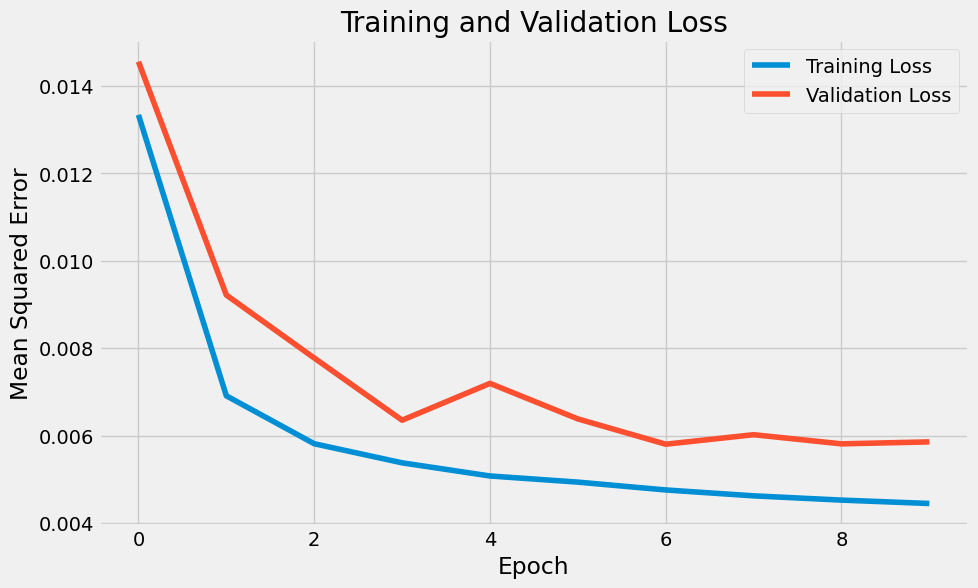

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [29]:
test_loss = model.evaluate(testX, testY, verbose=1)
print("Test Loss:", test_loss)

54/54 [==============================] - 1s 23ms/step - loss: 0.0077
Test Loss: 0.00774674117565155


In [30]:
train_dates = train_dates1[:6856]
test_dates = train_dates1[6856:]

In [31]:
predictions = model.predict(testX)

54/54 [==============================] - 1s 23ms/step


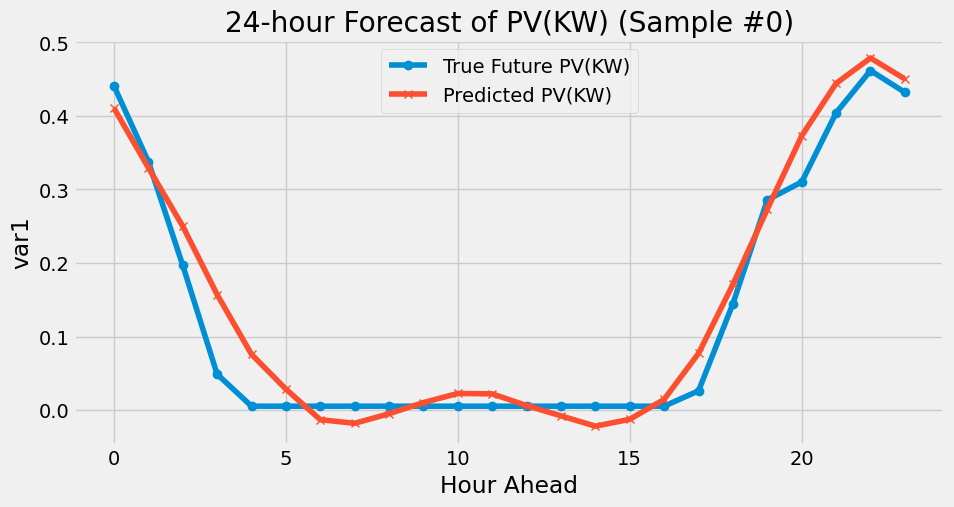

In [35]:
true_values = testY[0]         
predicted_values = predictions[0]
sample_index = 0
hours = np.arange(24)
plt.figure(figsize=(10, 5))
plt.plot(hours, true_values, label='True Future PV(KW)', marker='o')
plt.plot(hours, predicted_values, label='Predicted PV(KW)', marker='x')
plt.xlabel('Hour Ahead')
plt.ylabel('var1')
plt.title(f'24-hour Forecast of PV(KW) (Sample #{sample_index})')
plt.legend()
plt.grid(True)
plt.show()

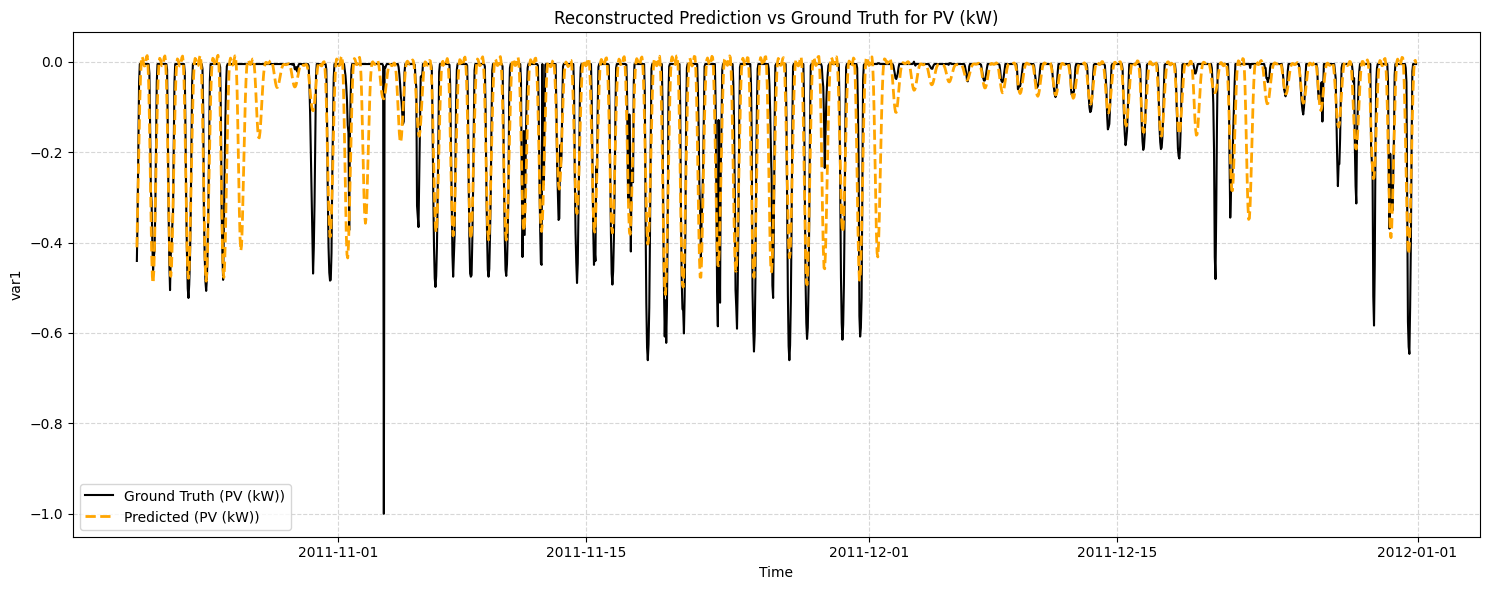

In [39]:
def reconstruct_sequence(windows):
    total_length = windows.shape[0] + windows.shape[1] - 1
    result = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(windows.shape[0]):
        result[i:i+24] += windows[i]
        count[i:i+24] += 1

    averaged = result / count
    return averaged
pred_series = reconstruct_sequence(predictions)
true_series = reconstruct_sequence(testY)

full_time_index = df_for_training.index
test_start_index = len(trainY)
reconstructed_time_index = full_time_index[test_start_index + n_past - 1 : test_start_index + n_past - 1 + len(pred_series)]



plt.style.use("default")
plt.figure(figsize=(15, 6))
plt.plot(reconstructed_time_index, true_series*(-1), label='Ground Truth (PV (kW))', color='black', linewidth=1.5)
plt.plot(reconstructed_time_index, pred_series*(-1), label='Predicted (PV (kW))', color='orange', linewidth=2, linestyle='--')
plt.xlabel("Time")
plt.ylabel("var1")
plt.title("Reconstructed Prediction vs Ground Truth for PV (kW)")
#plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()